In [6]:
!pip3 install handyspark

You should consider upgrading via the 'pip install --upgrade pip' command.


In [7]:
from handyspark import *

In [8]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.mllib.stat import Statistics
from pyspark.ml.linalg import DenseVector
from pyspark.sql import functions as F

In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [10]:
from pyspark.sql import SparkSession

In [11]:
spark = SparkSession\
    .builder\
    .appName("LC_Baseline_Model")\
    .config("spark.executor.memory","1g")\
    .config("spark.executor.cores","8")\
    .config("spark.driver.memory","1g")\
    .getOrCreate()

In [12]:
spark.sql("show tables").show()

+--------+-------------------+-----------+
|database|          tableName|isTemporary|
+--------+-------------------+-----------+
| default|   airlinesentiment|      false|
| default|                foo|      false|
| default|            james_p|      false|
| default|     james_sparlsql|      false|
| default|          james_tbl|      false|
| default|lc_loans_2015_model|      false|
| default|     my_first_table|      false|
| default|           products|      false|
| default|            sensors|      false|
| default|                 t1|      false|
| default|     telco_churn_pq|      false|
| default|         test_india|      false|
| default|          test_kudu|      false|
| default|              words|      false|
+--------+-------------------+-----------+



In [13]:
#spark.sql("SELECT * FROM global_temp.lc_loans_2015_model")

In [14]:
#df = spark.read.csv('data/LoanStats_2015_subset.csv')
df = spark.read.option('inferschema','true').csv('data/Data_Exploration.csv', header=True)

In [15]:
#df = df.limit(10000)

#### Feature Selection

In [16]:
df.dtypes

[('acc_now_delinq', 'int'),
 ('acc_open_past_24mths', 'int'),
 ('addr_state', 'string'),
 ('annual_inc', 'double'),
 ('application_type', 'string'),
 ('avg_cur_bal', 'int'),
 ('chargeoff_within_12_mths', 'int'),
 ('collections_12_mths_ex_med', 'int'),
 ('delinq_2yrs', 'int'),
 ('delinq_amnt', 'int'),
 ('dti', 'double'),
 ('earliest_cr_line', 'string'),
 ('emp_length', 'string'),
 ('funded_amnt', 'int'),
 ('funded_amnt_inv', 'double'),
 ('grade', 'string'),
 ('home_ownership', 'string'),
 ('initial_list_status', 'string'),
 ('inq_last_6mths', 'int'),
 ('installment', 'double'),
 ('int_rate', 'double'),
 ('issue_d', 'string'),
 ('loan_amnt', 'int'),
 ('loan_status', 'string'),
 ('mo_sin_old_rev_tl_op', 'int'),
 ('mo_sin_rcnt_rev_tl_op', 'int'),
 ('mo_sin_rcnt_tl', 'int'),
 ('mort_acc', 'int'),
 ('num_accts_ever_120_pd', 'int'),
 ('num_actv_bc_tl', 'int'),
 ('num_actv_rev_tl', 'int'),
 ('num_bc_sats', 'int'),
 ('num_bc_tl', 'int'),
 ('num_il_tl', 'int'),
 ('num_op_rev_tl', 'int'),
 ('num_

Data Quality Checks

In [17]:
#We will drop this feature based on its imbalance
df.groupby('application_type').count().show()

+----------------+------+
|application_type| count|
+----------------+------+
|       Joint App|   511|
|      Individual|420583|
+----------------+------+



In [18]:
#We will drop this feature for now although it could be one hot encoded or transformed differently
df.select('emp_length').show(5)

+----------+
|emp_length|
+----------+
| 10+ years|
|    1 year|
| 10+ years|
|   2 years|
|  < 1 year|
+----------+
only showing top 5 rows



In [19]:
#We keep this feature
df.groupby('verification_status').count().show()

+-------------------+------+
|verification_status| count|
+-------------------+------+
|           Verified|123016|
|    Source Verified|179564|
|       Not Verified|118514|
+-------------------+------+



In [20]:
#We remove categorical features that have too broad a set of values, or are highly imbalanced, or could cause data leakage. 
#We can elaborate and use them for feature extraction later, but they are not needed for a baseline

remove = ['addr_state', 'earliest_cr_line', 'home_ownership', 'initial_list_status', 'issue_d', 'emp_length',
          'loan_status', 'purpose', 'sub_grade', 'term', 'title', 'zip_code', 'application_type']
df = df.drop(*remove)

Baseline Feature Exploration

In [21]:
#Creating list of categorical and numeric features
cat_cols = [item[0] for item in df.dtypes if item[1].startswith('string')]
num_cols = [item[0] for item in df.dtypes if item[1].startswith('in') or item[1].startswith('dou')]

In [22]:
cat_cols

['grade', 'verification_status']

In [23]:
#Creating a subset of the data with only numeric features:
df_num = df.select(num_cols)

In [24]:
features = df_num.rdd.map(lambda row: row[0:])

In [140]:
corr_mat=Statistics.corr(features, method="pearson")
corr_df = pd.DataFrame(corr_mat)

In [141]:
corr_df.index, corr_df.columns = df_num.columns, df_num.columns

In [142]:
#Dropping code features that are in numeric datatype (these are really categorical):
corr_df = corr_df.drop(['dti', 'num_rev_accts', 'policy_code', 'revol_util'], axis=1)
corr_df = corr_df.drop(['dti', 'num_rev_accts', 'policy_code', 'revol_util'], axis=0)

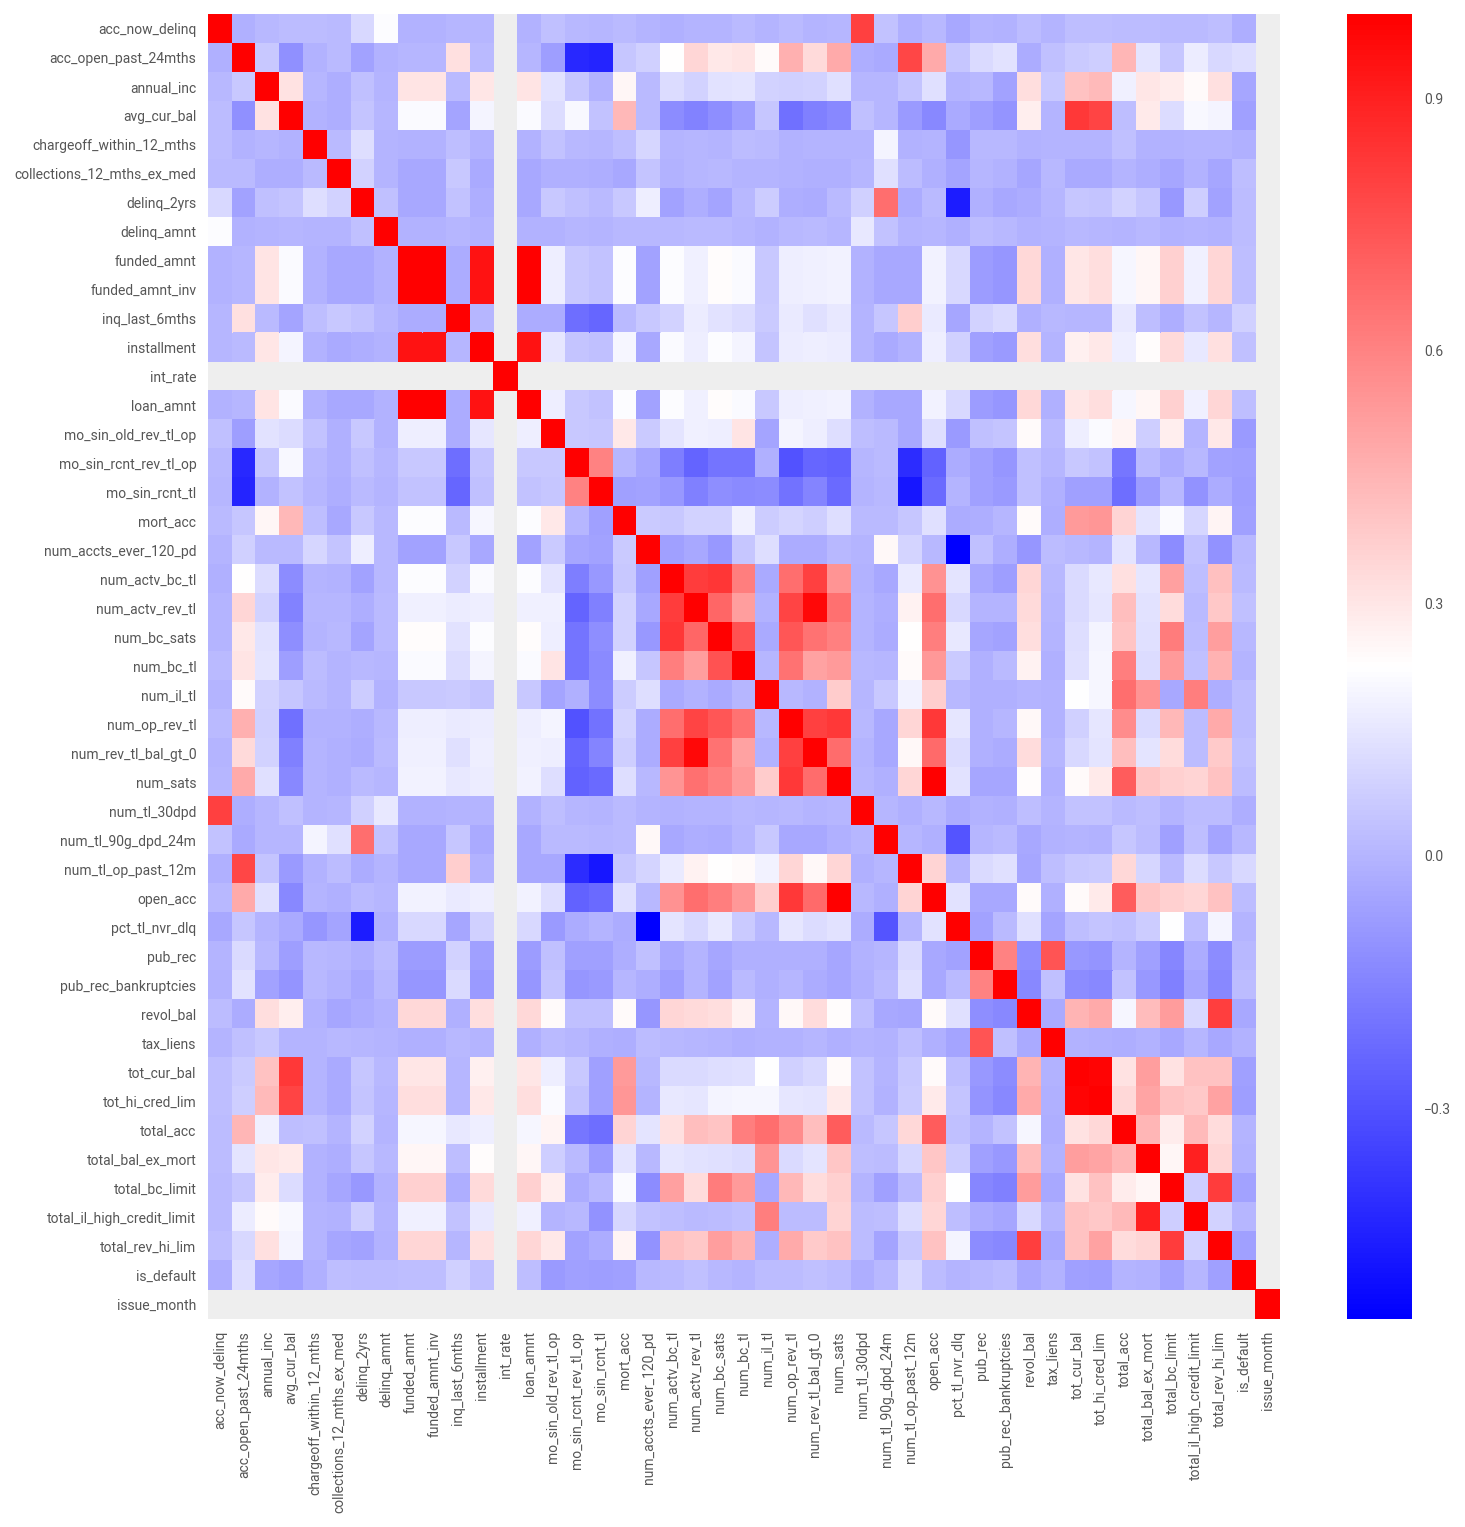

In [143]:
#Correlation Matrix between numeric columns
fig, ax = plt.subplots(figsize=(12,12))
sns.heatmap(corr_df, cbar=True, ax=ax, cmap='bwr')
plt.show()

In [144]:
#We only select features that are independent of one another
selected = corr_df[(corr_df>-0.4)&(corr_df<.04)]
#selected.columns

In [25]:
#We will choose these features for our baseline model:
num_features, cat_features = list(selected.columns), cat_cols

NameError: name 'selected' is not defined

In [ ]:
df_baseline = df.select(num_features + cat_features)

In [ ]:
df_baseline.count()

In [ ]:
#Dropping nulls
df_baseline = df_baseline.dropna()

In [ ]:
df_baseline.count()

In [ ]:
#Creates a Pipeline Object including One Hot Encoding of Categorical Features  
def make_pipeline(spark_df, num_att, cat_att):        
    stages= []

    for col in cat_att:

        stringIndexer = StringIndexer(inputCol = col , outputCol = col + '_StringIndex')
        encoder = OneHotEncoderEstimator(inputCols=[stringIndexer.getOutputCol()], outputCols=[col + '_ClassVect'])
        stages += [stringIndexer, encoder]

    #Assembling mixed data type transformations:
    assemblerInputs = [c + "_ClassVect" for c in cat_att] + num_att
    assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")

    stages += [assembler]

    #Creating and running the pipeline:
    pipeline = Pipeline(stages=stages)
    pipelineModel = pipeline.fit(spark_df)
    out_df = pipelineModel.transform(spark_df)
    
    return out_df

In [ ]:
df_model = make_pipeline(df_baseline, num_features, cat_features)

In [154]:
#df_model.columns

In [ ]:
df_model

In [155]:
input_data = df_model.rdd.map(lambda x: (x["is_default"], DenseVector(x["features"])))

In [156]:
df_pipeline = spark.createDataFrame(input_data, ["is_default", "features"])

In [157]:
df_pipeline.show()

+----------+--------------------+
|is_default|            features|
+----------+--------------------+
|         0|[1.0,0.0,0.0,0.0,...|
|         0|[0.0,0.0,1.0,0.0,...|
|         0|[0.0,0.0,0.0,1.0,...|
|         0|[0.0,0.0,0.0,1.0,...|
|         0|[0.0,0.0,0.0,0.0,...|
|         0|[1.0,0.0,0.0,0.0,...|
|         1|[0.0,0.0,0.0,1.0,...|
|         0|[0.0,0.0,1.0,0.0,...|
|         0|[1.0,0.0,0.0,0.0,...|
|         0|[0.0,1.0,0.0,0.0,...|
|         0|[0.0,0.0,1.0,0.0,...|
|         0|[0.0,0.0,0.0,1.0,...|
|         0|[0.0,1.0,0.0,0.0,...|
|         0|[0.0,1.0,0.0,0.0,...|
|         0|[0.0,0.0,0.0,1.0,...|
|         0|[0.0,1.0,0.0,0.0,...|
|         0|[0.0,0.0,1.0,0.0,...|
|         1|[0.0,0.0,0.0,1.0,...|
|         0|[0.0,1.0,0.0,0.0,...|
|         0|[0.0,1.0,0.0,0.0,...|
+----------+--------------------+
only showing top 20 rows



In [158]:
train, test = df_pipeline.randomSplit([0.8, 0.2], seed=1)

In [159]:
lr = LogisticRegression(featuresCol='features', labelCol='is_default', maxIter=10, regParam=0.3, elasticNetParam=0.8)

In [160]:
# Fit the model
lrModel = lr.fit(train)

In [161]:
# Print the coefficients and intercept for logistic regression
print("Coefficients: " + str(lrModel.coefficients))
print("Intercept: " + str(lrModel.intercept))

Coefficients: (53,[51],[1.378389137477208])
Intercept: -2.1278978861248716


In [162]:
# Make predictions on test data. model is the model with combination of parameters that performed best.
predictions = lrModel.transform(test)

In [164]:
predictions.select("features","is_default", "prediction", "probability").show()

+--------------------+----------+----------+--------------------+
|            features|is_default|prediction|         probability|
+--------------------+----------+----------+--------------------+
|[0.0,0.0,0.0,0.0,...|         0|       0.0|[0.89358528232055...|
|[0.0,0.0,0.0,0.0,...|         0|       0.0|[0.89358528232055...|
|[0.0,0.0,0.0,0.0,...|         0|       0.0|[0.89358528232055...|
|[0.0,0.0,0.0,0.0,...|         0|       0.0|[0.89358528232055...|
|[0.0,0.0,0.0,0.0,...|         0|       0.0|[0.89358528232055...|
|[0.0,0.0,0.0,0.0,...|         0|       0.0|[0.89358528232055...|
|[0.0,0.0,0.0,0.0,...|         0|       0.0|[0.89358528232055...|
|[0.0,0.0,0.0,0.0,...|         0|       0.0|[0.89358528232055...|
|[0.0,0.0,0.0,0.0,...|         0|       0.0|[0.89358528232055...|
|[0.0,0.0,0.0,0.0,...|         0|       0.0|[0.89358528232055...|
|[0.0,0.0,0.0,0.0,...|         0|       0.0|[0.89358528232055...|
|[0.0,0.0,0.0,0.0,...|         0|       0.0|[0.89358528232055...|
|[0.0,0.0,

In [170]:
predictions.select("is_default", "prediction").groupby('is_default').count().show()

+----------+-----+
|is_default|count|
+----------+-----+
|         0| 1479|
|         1|  213|
+----------+-----+



In [171]:
predictions.select("is_default", "prediction").groupby('prediction').count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|       0.0| 1701|
+----------+-----+



In [169]:
preds_df = predictions.select("is_default", "prediction")
predictions.select("is_default", "prediction").filter(preds_df.is_default == preds_df.prediction).count() / preds_df.count()

0.873015873015873

Model Evaluation

In [208]:
evaluator = BinaryClassificationEvaluator(labelCol="is_default", rawPredictionCol="prediction")

In [209]:
auroc = evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})
auprc = evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderPR"})

In [210]:
print("Area under ROC Curve: {:.4f}".format(auroc))
print("Area under PR Curve: {:.4f}".format(auprc))

Area under ROC Curve: 0.5000
Area under PR Curve: 0.1270


In [211]:
# Handy Spark Library 
# Creates instance of extended version of BinaryClassificationMetrics
# using a DataFrame and its probability and label columns, as the output
# from the classifier
bcm = BinaryClassificationMetrics(predictions, scoreCol='probability', labelCol='is_default')

Exception ignored in: <object repr() failed>
Traceback (most recent call last):
  File "/etc/spark/python/lib/pyspark.zip/pyspark/ml/wrapper.py", line 40, in __del__
AttributeError: 'BinaryClassificationEvaluator' object has no attribute '_java_obj'


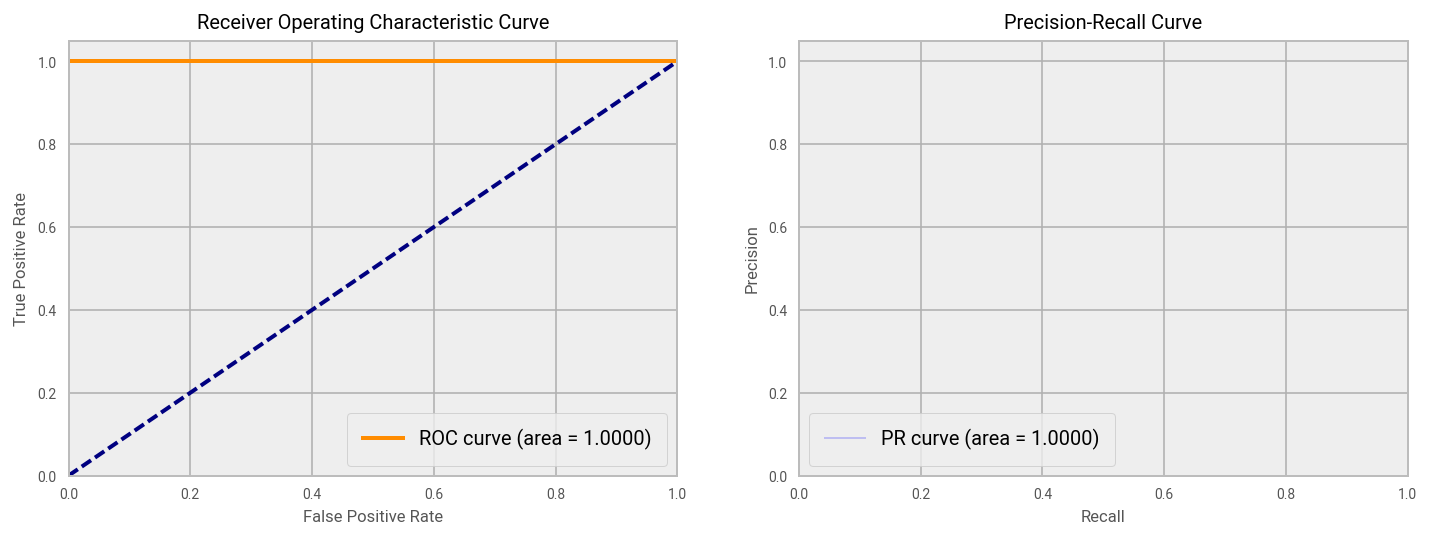

In [213]:
# Now we can PLOT both ROC and PR curves!
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
bcm.plot_roc_curve(ax=axs[0])
bcm.plot_pr_curve(ax=axs[1])
plt.show()

In [214]:
# We can also get all metrics (FPR, Recall and Precision) by threshold
bcm.getMetricsByThreshold().filter('fpr between 0.19 and 0.21').toPandas()

,threshold,fpr,recall,precision


In [303]:
# And get the confusion matrix for any threshold we want
cm = bcm.print_confusion_matrix(.5)

In [311]:
from confusion_matrix_pretty_print import pretty_plot_confusion_matrix

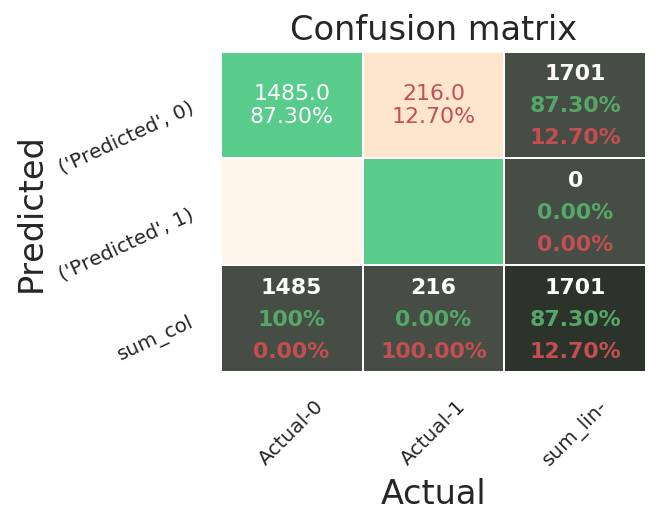

In [315]:
pretty_plot_confusion_matrix(cm, figsize=[5,4])
plt.show()

In [ ]:
#writing train and test data for lineage

In [216]:
train.toPandas().to_csv('data/baseline/train.csv', index=False)

In [388]:
train_pd= train.toPandas()

In [389]:
spark.createDataFrame(train_pd).show()

+----------+--------------------+
|is_default|            features|
+----------+--------------------+
|         0|[0.0,0.0,0.0,0.0,...|
|         0|[0.0,0.0,0.0,0.0,...|
|         0|[0.0,0.0,0.0,0.0,...|
|         0|[0.0,0.0,0.0,0.0,...|
|         0|[0.0,0.0,0.0,0.0,...|
|         0|[0.0,0.0,0.0,0.0,...|
|         0|[0.0,0.0,0.0,0.0,...|
|         0|[0.0,0.0,0.0,0.0,...|
|         0|[0.0,0.0,0.0,0.0,...|
|         0|[0.0,0.0,0.0,0.0,...|
|         0|[0.0,0.0,0.0,0.0,...|
|         0|[0.0,0.0,0.0,0.0,...|
|         0|[0.0,0.0,0.0,0.0,...|
|         0|[0.0,0.0,0.0,0.0,...|
|         0|[0.0,0.0,0.0,0.0,...|
|         0|[0.0,0.0,0.0,0.0,...|
|         0|[0.0,0.0,0.0,0.0,...|
|         0|[0.0,0.0,0.0,0.0,...|
|         0|[0.0,0.0,0.0,0.0,...|
|         0|[0.0,0.0,0.0,0.0,...|
+----------+--------------------+
only showing top 20 rows



In [217]:
#test.toPandas().to_csv('data/baseline/test.csv', index=False)

In [ ]:
#Hyperparameter tuning

In [316]:
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit, CrossValidator

In [219]:
# We use a ParamGridBuilder to construct a grid of parameters to search over.
# TrainValidationSplit will try all combinations of values and determine best model using
# the evaluator.
paramGrid = ParamGridBuilder()\
    .addGrid(lr.regParam, [0.1, 0.01]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 0.7, 0.8, 0.9, 1.0])\
    .build()

In [220]:
evaluator = BinaryClassificationEvaluator(labelCol="is_default")

In [356]:
crossval = CrossValidator(estimator=lr,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=3, collectSubModels=True) 

In [357]:
# Run cross-validation, and choose the best set of parameters.
cvModel = crossval.fit(train)

In [358]:
prediction = cvModel.transform(test)

In [359]:
selected = prediction.select("is_default", "probability", "prediction")

In [360]:
cvModel.bestModel.summary

In [361]:
cvModel.bestModel.summary.recallByThreshold

DataFrame[threshold: double, recall: double]

In [362]:
cvModel.bestModel.summary.precisionByThreshold

DataFrame[threshold: double, precision: double]

In [363]:
cvModel.bestModel.summary.accuracy

1.0

In [364]:
cvModel.bestModel.summary.areaUnderROC

0.9999507589376436

In [365]:
cvModel.bestModel.summary.recallByLabel

[1.0, 1.0]

In [366]:
cvModel.bestModel._java_obj.getRegParam()
cvModel.bestModel._java_obj.getMaxIter()
cvModel.bestModel._java_obj.getElasticNetParam()

0.0

In [367]:
pd.DataFrame(cvModel.bestModel.summary.objectiveHistory)

,0
0,0.396018
1,0.262540
2,0.214164
3,0.193590
4,0.186594
5,0.184556
6,0.182560
7,0.175518
8,0.172858
9,0.172444


In [368]:
cvModel.avgMetrics

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

In [374]:
for i in cvModel.subModels:
    for model in i:
        print(model.summary.accuracy)

1.0
1.0
1.0
1.0
1.0041133455210238
1.0
0.9959035047792444
0.9959035047792444
1.0041133455210238
1.0
1.0
1.0
1.0
1.0059578368469295
1.0
1.0059578368469295
1.0
1.0059578368469295
1.0
0.9940774487471526
1.0059578368469295
1.0059578368469295
1.0
1.0059578368469295
1.0
1.0
0.9941546762589928
1.0
1.0
1.0
0.9997738579828132
1.0
1.0
1.0
1.0058796924468567
0.9941546762589928


In [382]:
list(zip([model.summary.accuracy for model in cvModel.subModels[0]], 
    [model.summary.accuracy for model in cvModel.subModels[1]], 
    [model.summary.accuracy for model in cvModel.subModels[2]]))

[(1.0, 1.0, 1.0),
 (1.0, 1.0059578368469295, 1.0),
 (1.0, 1.0, 0.9941546762589928),
 (1.0, 1.0059578368469295, 1.0),
 (1.0041133455210238, 1.0, 1.0),
 (1.0, 1.0059578368469295, 1.0),
 (0.9959035047792444, 1.0, 0.9997738579828132),
 (0.9959035047792444, 0.9940774487471526, 1.0),
 (1.0041133455210238, 1.0059578368469295, 1.0),
 (1.0, 1.0059578368469295, 1.0),
 (1.0, 1.0, 1.0058796924468567),
 (1.0, 1.0059578368469295, 0.9941546762589928)]

In [385]:
train.show()

+----------+--------------------+
|is_default|            features|
+----------+--------------------+
|         0|[0.0,0.0,0.0,0.0,...|
|         0|[0.0,0.0,0.0,0.0,...|
|         0|[0.0,0.0,0.0,0.0,...|
|         0|[0.0,0.0,0.0,0.0,...|
|         0|[0.0,0.0,0.0,0.0,...|
|         0|[0.0,0.0,0.0,0.0,...|
|         0|[0.0,0.0,0.0,0.0,...|
|         0|[0.0,0.0,0.0,0.0,...|
|         0|[0.0,0.0,0.0,0.0,...|
|         0|[0.0,0.0,0.0,0.0,...|
|         0|[0.0,0.0,0.0,0.0,...|
|         0|[0.0,0.0,0.0,0.0,...|
|         0|[0.0,0.0,0.0,0.0,...|
|         0|[0.0,0.0,0.0,0.0,...|
|         0|[0.0,0.0,0.0,0.0,...|
|         0|[0.0,0.0,0.0,0.0,...|
|         0|[0.0,0.0,0.0,0.0,...|
|         0|[0.0,0.0,0.0,0.0,...|
|         0|[0.0,0.0,0.0,0.0,...|
|         0|[0.0,0.0,0.0,0.0,...|
+----------+--------------------+
only showing top 20 rows



In [241]:
# In this case the estimator is simply the logistic regression.
# A TrainValidationSplit requires an Estimator, a set of Estimator ParamMaps, and an Evaluator.
tvs = TrainValidationSplit(estimator=lr,
                           estimatorParamMaps=paramGrid,
                           evaluator=evaluator,
                           # 80% of the data will be used for training, 20% for validation.
                           trainRatio=0.8)

In [242]:
tvs.setCollectSubModels(True)

TrainValidationSplit_8f552da362bc

In [243]:
# Run TrainValidationSplit, and choose the best set of parameters.
model = tvs.fit(train)

In [273]:
model.bestModel.summary

In [244]:
# Make predictions on test data. model is the model with combination of parameters
# that performed best.
predictions_ht = model.transform(test)

In [259]:
#for learning curves for given model> specifies cost function at each iteration
model.subModels[1].summary.objectiveHistory

[0.3998537532364242,
 0.35217362526321316,
 0.29014277038430636,
 0.23509484275931694,
 0.21167070833355528,
 0.20716902896036318,
 0.2060997915892925,
 0.20609685046617543,
 0.2060089771296738,
 0.20476787800541163,
 0.20443482719890943]

In [ ]:
#remember to set parallelism to -1 in train val split and others

In [271]:
len(model.validationMetrics)

12

In [275]:
model.validationMetrics

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

In [276]:
for i in model.subModels:
    print(i.summary.accuracy)

0.9943460233697701
1.0056861258529188
0.9943460233697701
1.0
1.0
1.0
1.0
1.0
1.0056861258529188
1.0
1.0056861258529188
1.0


In [260]:
len(model.subModels)

12

In [263]:
model.subModels[1].summary.accuracy

1.0056861258529188

In [277]:
model.subModels[1].summary

In [ ]:
#Can also do this

In [287]:
evaluator_acc = BinaryClassificationEvaluator(labelCol="is_default",predictionCol="prediction", metricName="accuracy")

In [290]:
accuracy = evaluator.evaluate(predictions)

In [291]:
accuracy

1.0

In [298]:
evaluator_ac = BinaryClassificationEvaluator(labelCol="is_default", metricName="recall")

In [300]:
recall = evaluator.evaluate(predictions)

In [301]:
recall

1.0

In [387]:
cvModel.bestModel.summary.recallByThreshold.toPandas().to_csv("data/baseline/CV_results/CV_recall_by_treshold.csv")
cvModel.bestModel.summary.precisionByThreshold.toPandas().to_csv("data/baseline/CV_results/CV_precision_by_treshold.csv")
pd.DataFrame(cvModel.bestModel.summary.objectiveHistory).to_csv("data/baseline/CV_results/CV_objective_history.csv")

In [ ]:
select threshold for best model and then do cost benefit analysis. How do costs and profits change as I move threshold up and down. 

In [ ]:
Do CV and get best model. Then do val curves and learning curves for it. 

In [ ]:
Validation Curves: do model across two hyperparameter dimensions and get accuracy at each value. Then plot multiple for each 

Learning curves: separate data independently into train and val, then do one TrainValidationSplit with all train and one TrainValidationSplit with all val to get scores

In [ ]:
#CrossValidatorModel avgMEtrics: average corss val metrics for each paramMap

In [226]:
# Extract the summary from the returned LogisticRegressionModel instance trained
# in the earlier example
trainingSummary = lrModel.summary

Exception ignored in: <object repr() failed>
Traceback (most recent call last):
  File "/etc/spark/python/lib/pyspark.zip/pyspark/ml/wrapper.py", line 40, in __del__
AttributeError: 'BinaryClassificationEvaluator' object has no attribute '_java_obj'


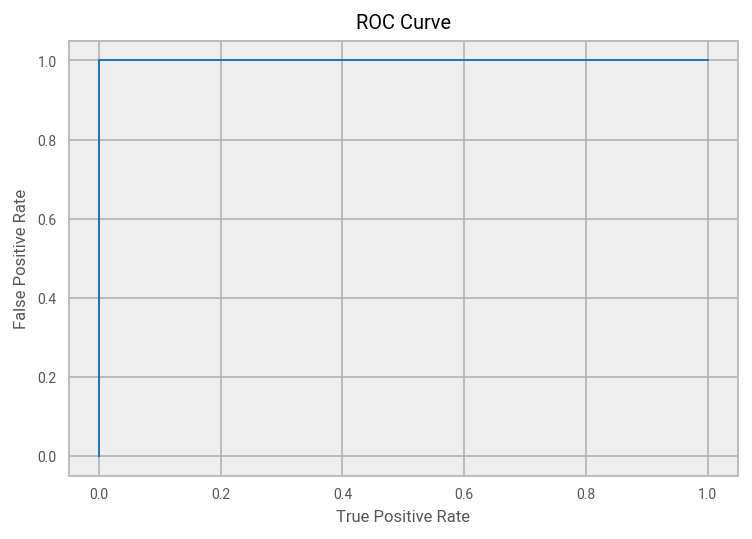

In [227]:
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [228]:
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

Training set areaUnderROC: 1.0


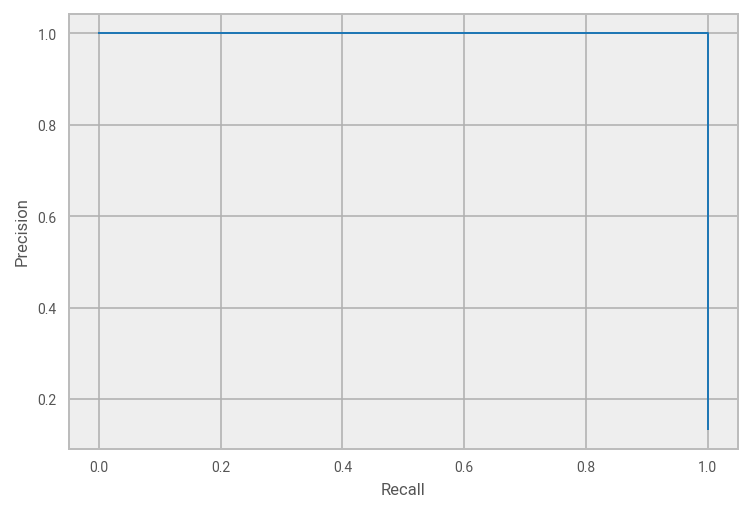

In [229]:
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

In [230]:
# Obtain the objective per iteration
objectiveHistory = trainingSummary.objectiveHistory
print("objectiveHistory:")
for objective in objectiveHistory:
    print(objective)

objectiveHistory:
0.3993130226990159
0.3934233823822184
0.3778851164000152
0.3773064015995975
0.3766276778563566
0.37652792092504356
0.3764349383741362
0.3759882833128789
0.3736064329218666
0.3731875517987291
0.37317442016678193


In [231]:
# Obtain the receiver-operating characteristic as a dataframe and areaUnderROC.
trainingSummary.roc.show()
print("areaUnderROC: " + str(trainingSummary.areaUnderROC))

+---+---+
|FPR|TPR|
+---+---+
|0.0|0.0|
|0.0|1.0|
|1.0|1.0|
|1.0|1.0|
+---+---+

areaUnderROC: 1.0


In [232]:
# Set the model threshold to maximize F-Measure
fMeasure = trainingSummary.fMeasureByThreshold
maxFMeasure = fMeasure.groupBy().max('F-Measure').select('max(F-Measure)').head()
bestThreshold = fMeasure.where(fMeasure['F-Measure'] == maxFMeasure['max(F-Measure)']) \
    .select('threshold').head()['threshold']

In [233]:
lr.setThreshold(bestThreshold)

LogisticRegression_762037d506c4

In [234]:
bestThreshold

0.3209283514555939

In [235]:
trainingSummary

In [237]:
objectiveHistory

[0.3993130226990159,
 0.3934233823822184,
 0.3778851164000152,
 0.3773064015995975,
 0.3766276778563566,
 0.37652792092504356,
 0.3764349383741362,
 0.3759882833128789,
 0.3736064329218666,
 0.3731875517987291,
 0.37317442016678193]